# Chapter 5: Single Predictor Models

**Building the Foundation for Multiple Regression**

## Goal

Fit **univariate models** to understand each predictor's relationship with divorce rate:

1. **M5.1:** Divorce ~ Age at marriage
2. **M5.2:** Divorce ~ Marriage rate

These establish baselines before we add multiple predictors.

## The Bayesian Workflow

For each model:
1. Specify priors
2. Prior predictive checks
3. Fit with quap
4. Posterior analysis
5. Posterior predictive checks

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

plt.style.use('default')
%matplotlib inline

np.random.seed(42)

print('✓ Imports loaded')

✓ Imports loaded


In [2]:
# Import quap
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent.parent))
from src.quap import quap, QuapResult

print('✓ Loaded quap')

✓ Loaded quap


---

## Step 1: Load and Prepare Data

We'll use **standardized** variables for modeling.

In [3]:
# Load data
url = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/WaffleDivorce.csv"
waffle_data = pd.read_csv(url, sep=";")

# Standardize variables
divorce = waffle_data['Divorce'].values
marriage = waffle_data['Marriage'].values
age = waffle_data['MedianAgeMarriage'].values

# Standardize: z = (x - mean) / sd
D = (divorce - divorce.mean()) / divorce.std()
M = (marriage - marriage.mean()) / marriage.std()
A = (age - age.mean()) / age.std()

print(f"Sample size: {len(D)}")
print(f"\nStandardized variables (should have mean≈0, std≈1):")
print(f"  D: mean={D.mean():.3f}, std={D.std():.3f}")
print(f"  M: mean={M.mean():.3f}, std={M.std():.3f}")
print(f"  A: mean={A.mean():.3f}, std={A.std():.3f}")

Sample size: 50

Standardized variables (should have mean≈0, std≈1):
  D: mean=-0.000, std=1.000
  M: mean=-0.000, std=1.000
  A: mean=0.000, std=1.000


---

## Model M5.1: Divorce ~ Age at Marriage

### Model Specification

$$D_i \sim \text{Normal}(\mu_i, \sigma)$$
$$\mu_i = \alpha + \beta_A \cdot A_i$$

**Priors:**
$$\alpha \sim \text{Normal}(0, 0.2)$$
$$\beta_A \sim \text{Normal}(0, 0.5)$$
$$\sigma \sim \text{Exponential}(1)$$

### Why These Priors?

**α ~ Normal(0, 0.2):**
- D is standardized, so mean divorce should be near 0
- SD=0.2 means 95% prior probability α is in [-0.4, 0.4]
- That's ±2 standard deviations on the outcome scale

**β ~ Normal(0, 0.5):**
- Both predictors and outcome are standardized
- β represents change in SD of outcome per SD of predictor
- SD=0.5 is mildly regularizing
- 95% prior: β in [-1, 1] (reasonable range)

**σ ~ Exponential(1):**
- Outcome is standardized (sd=1)
- Most variation should be explained by model
- Exponential(1) concentrates mass near 0, allows larger values

### Step 1: Prior Predictive Simulation

**Before seeing data**, what relationships do our priors imply?

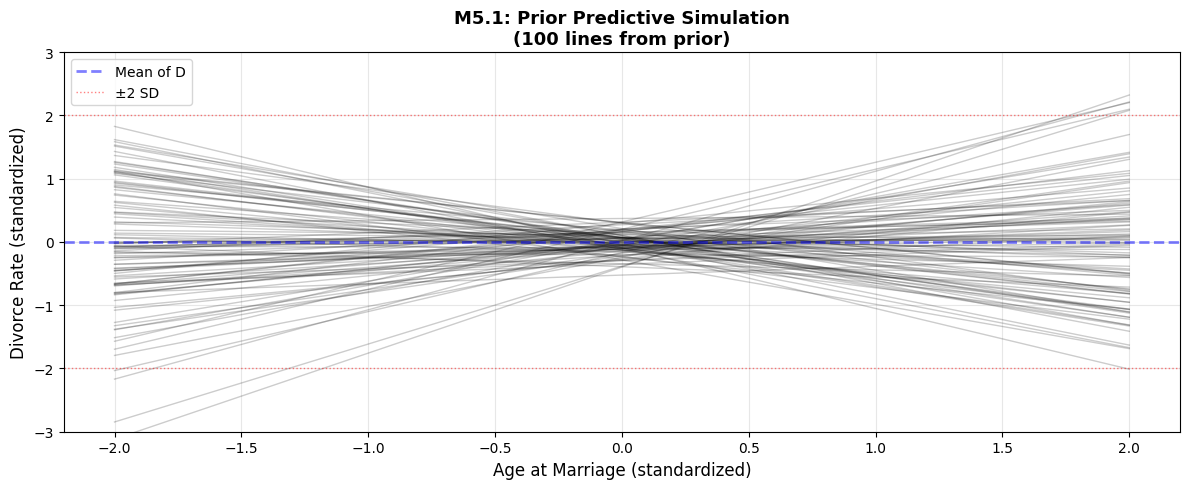

Prior Check:
• Lines are reasonable (mostly within ±2 SD)
• Some positive, some negative slopes (no strong bias)
• Weakly informative - allows data to dominate


In [4]:
# Prior predictive simulation for M5.1
n_prior_samples = 100
A_seq = np.linspace(-2, 2, 50)  # Range of standardized age values

# Sample from priors
alpha_prior = np.random.normal(0, 0.2, n_prior_samples)
beta_A_prior = np.random.normal(0, 0.5, n_prior_samples)
sigma_prior = np.random.exponential(1, n_prior_samples)

# Generate prior predictions
plt.figure(figsize=(12, 5))

for i in range(n_prior_samples):
    mu = alpha_prior[i] + beta_A_prior[i] * A_seq
    plt.plot(A_seq, mu, 'k-', alpha=0.2, linewidth=1)

plt.axhline(0, color='blue', linestyle='--', linewidth=2, alpha=0.5, label='Mean of D')
plt.axhline(-2, color='red', linestyle=':', linewidth=1, alpha=0.5)
plt.axhline(2, color='red', linestyle=':', linewidth=1, alpha=0.5, label='±2 SD')
plt.xlabel('Age at Marriage (standardized)', fontsize=12)
plt.ylabel('Divorce Rate (standardized)', fontsize=12)
plt.title('M5.1: Prior Predictive Simulation\n(100 lines from prior)', 
          fontsize=13, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.ylim(-3, 3)
plt.tight_layout()
plt.show()

print("Prior Check:")
print("• Lines are reasonable (mostly within ±2 SD)")
print("• Some positive, some negative slopes (no strong bias)")
print("• Weakly informative - allows data to dominate")

### Step 2: Fit Model M5.1 with Quap

In [5]:
def neg_log_posterior_m51(params):
    """
    M5.1: D ~ α + βA·A
    
    Parameters: [alpha, beta_A, log_sigma]
    """
    alpha = params[0]
    beta_A = params[1]
    log_sigma = params[2]
    sigma = np.exp(log_sigma)
    
    # Linear model
    mu = alpha + beta_A * A
    
    # Likelihood: D ~ Normal(mu, sigma)
    log_lik = np.sum(stats.norm.logpdf(D, loc=mu, scale=sigma))
    
    # Priors
    log_prior_alpha = stats.norm.logpdf(alpha, loc=0, scale=0.2)
    log_prior_beta_A = stats.norm.logpdf(beta_A, loc=0, scale=0.5)
    log_prior_log_sigma = stats.expon.logpdf(sigma, scale=1)  # σ ~ Exponential(1)
    
    # Jacobian for log transform
    jacobian = log_sigma
    
    log_posterior = log_lik + log_prior_alpha + log_prior_beta_A + log_prior_log_sigma + jacobian
    
    return -log_posterior

# Initial values
initial_params_m51 = [0.0, 0.0, np.log(1.0)]
param_names_m51 = ['alpha', 'beta_A', 'log_sigma']

# Fit
print("Fitting M5.1: Divorce ~ Age...")
m51 = quap(neg_log_posterior_m51, initial_params_m51, param_names_m51)
print("✓ Model fitted\n")

# Summary
m51.summary()

Fitting M5.1: Divorce ~ Age...
✓ Model fitted

QUAP POSTERIOR APPROXIMATION
Converged: True
Time: 0.0136 seconds
Log posterior at MAP: -61.15

             mean    std  89%_lower  89%_upper
alpha      0.0000 0.0989    -0.1580     0.1580
beta_A    -0.5679 0.1110    -0.7453    -0.3904
log_sigma -0.2179 0.0999    -0.3776    -0.0582


,mean,std,89%_lower,89%_upper
alpha,1.188644e-08,0.098862,-0.158001,0.158001
beta_A,-5.678603e-01,0.111036,-0.745317,-0.390404
log_sigma,-2.179354e-01,0.099921,-0.377628,-0.058243


### Step 3: Interpret M5.1 Results

In [6]:
# Extract coefficients
coef_m51 = m51.coef()
sigma_m51 = np.exp(coef_m51['log_sigma'])

print("M5.1 Interpretation:")
print("="*70)
print(f"α = {coef_m51['alpha']:.3f}")
print("  → Mean divorce rate when A=0 (average age)")
print(f"\nβA = {coef_m51['beta_A']:.3f}")
print("  → Change in divorce per 1 SD increase in age")
if coef_m51['beta_A'] < 0:
    print("  → NEGATIVE: Older marriage age → Lower divorce")
else:
    print("  → POSITIVE: Older marriage age → Higher divorce")
print(f"\nσ = {sigma_m51:.3f}")
print("  → Residual variation after accounting for age")

M5.1 Interpretation:
α = 0.000
  → Mean divorce rate when A=0 (average age)

βA = -0.568
  → Change in divorce per 1 SD increase in age
  → NEGATIVE: Older marriage age → Lower divorce

σ = 0.804
  → Residual variation after accounting for age


### Step 4: Posterior Prediction Plot

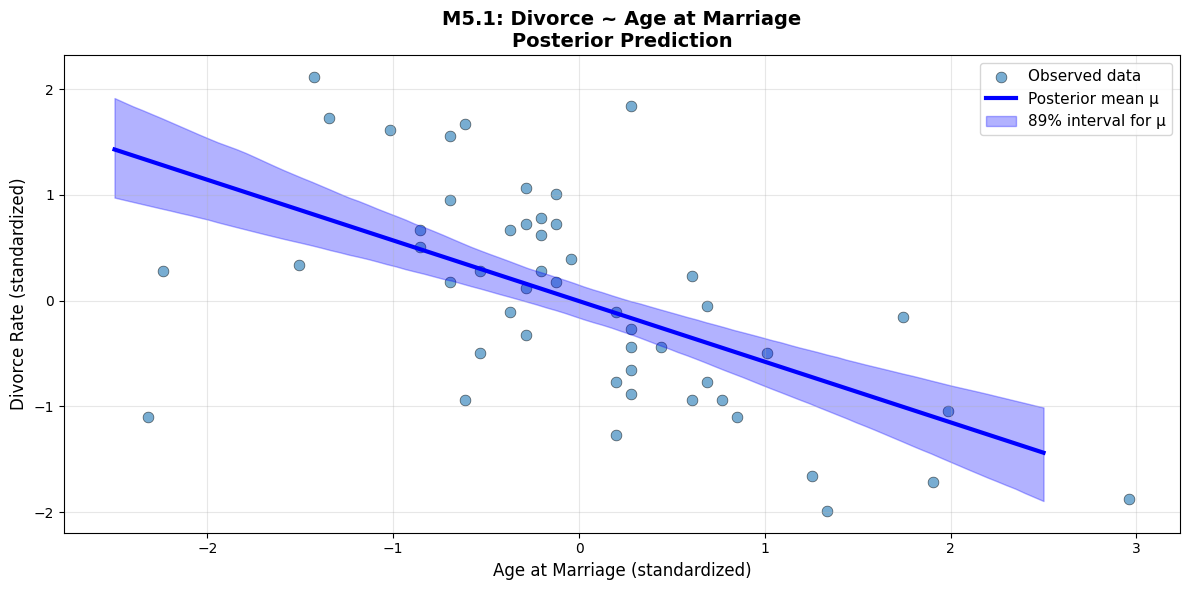

✓ Strong negative relationship: Older age → Lower divorce


In [7]:
# Generate predictions
A_seq = np.linspace(-2.5, 2.5, 100)
post_m51 = m51.sample(n=1000, seed=42)

# Compute μ for each sample
mu_samples = post_m51['alpha'].values[:, None] + post_m51['beta_A'].values[:, None] * A_seq[None, :]

# Summary statistics
mu_mean = mu_samples.mean(axis=0)
mu_lower = np.percentile(mu_samples, 5.5, axis=0)
mu_upper = np.percentile(mu_samples, 94.5, axis=0)

# Plot
plt.figure(figsize=(12, 6))

# Data points
plt.scatter(A, D, alpha=0.6, s=60, edgecolor='black', linewidth=0.5, label='Observed data')

# Mean line
plt.plot(A_seq, mu_mean, 'b-', linewidth=3, label='Posterior mean μ')

# Uncertainty band
plt.fill_between(A_seq, mu_lower, mu_upper, alpha=0.3, color='blue', label='89% interval for μ')

plt.xlabel('Age at Marriage (standardized)', fontsize=12)
plt.ylabel('Divorce Rate (standardized)', fontsize=12)
plt.title('M5.1: Divorce ~ Age at Marriage\nPosterior Prediction', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✓ Strong negative relationship: Older age → Lower divorce")

---

## Model M5.2: Divorce ~ Marriage Rate

### Model Specification

$$D_i \sim \text{Normal}(\mu_i, \sigma)$$
$$\mu_i = \alpha + \beta_M \cdot M_i$$

**Same priors as M5.1:**
$$\alpha \sim \text{Normal}(0, 0.2)$$
$$\beta_M \sim \text{Normal}(0, 0.5)$$
$$\sigma \sim \text{Exponential}(1)$$

### Step 1: Prior Predictive Check M5.2

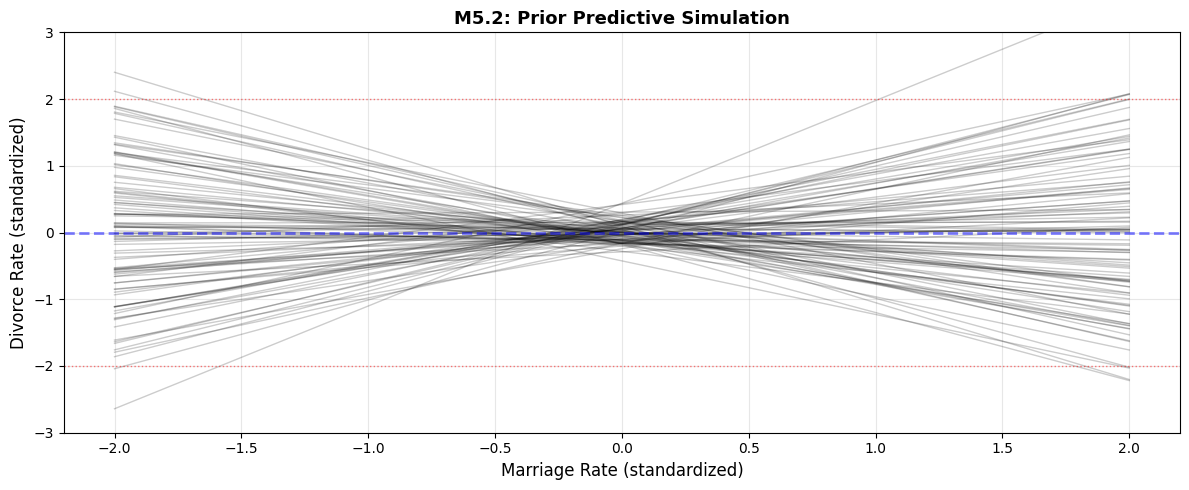

In [8]:
# Prior predictive (same logic as M5.1)
M_seq = np.linspace(-2, 2, 50)

alpha_prior = np.random.normal(0, 0.2, n_prior_samples)
beta_M_prior = np.random.normal(0, 0.5, n_prior_samples)

plt.figure(figsize=(12, 5))

for i in range(n_prior_samples):
    mu = alpha_prior[i] + beta_M_prior[i] * M_seq
    plt.plot(M_seq, mu, 'k-', alpha=0.2, linewidth=1)

plt.axhline(0, color='blue', linestyle='--', linewidth=2, alpha=0.5)
plt.axhline(-2, color='red', linestyle=':', linewidth=1, alpha=0.5)
plt.axhline(2, color='red', linestyle=':', linewidth=1, alpha=0.5)
plt.xlabel('Marriage Rate (standardized)', fontsize=12)
plt.ylabel('Divorce Rate (standardized)', fontsize=12)
plt.title('M5.2: Prior Predictive Simulation', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.ylim(-3, 3)
plt.tight_layout()
plt.show()

### Step 2: Fit Model M5.2

In [9]:
def neg_log_posterior_m52(params):
    """
    M5.2: D ~ α + βM·M
    
    Parameters: [alpha, beta_M, log_sigma]
    """
    alpha = params[0]
    beta_M = params[1]
    log_sigma = params[2]
    sigma = np.exp(log_sigma)
    
    # Linear model
    mu = alpha + beta_M * M
    
    # Likelihood
    log_lik = np.sum(stats.norm.logpdf(D, loc=mu, scale=sigma))
    
    # Priors
    log_prior_alpha = stats.norm.logpdf(alpha, loc=0, scale=0.2)
    log_prior_beta_M = stats.norm.logpdf(beta_M, loc=0, scale=0.5)
    log_prior_log_sigma = stats.expon.logpdf(sigma, scale=1)
    
    # Jacobian
    jacobian = log_sigma
    
    log_posterior = log_lik + log_prior_alpha + log_prior_beta_M + log_prior_log_sigma + jacobian
    
    return -log_posterior

# Fit
initial_params_m52 = [0.0, 0.0, np.log(1.0)]
param_names_m52 = ['alpha', 'beta_M', 'log_sigma']

print("Fitting M5.2: Divorce ~ Marriage Rate...")
m52 = quap(neg_log_posterior_m52, initial_params_m52, param_names_m52)
print("✓ Model fitted\n")

m52.summary()

Fitting M5.2: Divorce ~ Marriage Rate...
✓ Model fitted

QUAP POSTERIOR APPROXIMATION
Converged: True
Time: 0.0111 seconds
Log posterior at MAP: -67.99

             mean    std  89%_lower  89%_upper
alpha      0.0000 0.1098    -0.1754     0.1754
beta_M     0.3496 0.1271     0.1465     0.5527
log_sigma -0.0742 0.0997    -0.2335     0.0851


,mean,std,89%_lower,89%_upper
alpha,6.371688e-09,0.109767,-0.175430,0.175430
beta_M,3.496181e-01,0.127085,0.146512,0.552724
log_sigma,-7.416938e-02,0.099672,-0.233464,0.085126


### Step 3: Interpret M5.2 Results

In [10]:
coef_m52 = m52.coef()
sigma_m52 = np.exp(coef_m52['log_sigma'])

print("M5.2 Interpretation:")
print("="*70)
print(f"α = {coef_m52['alpha']:.3f}")
print("  → Mean divorce when M=0 (average marriage rate)")
print(f"\nβM = {coef_m52['beta_M']:.3f}")
print("  → Change in divorce per 1 SD increase in marriage rate")
if coef_m52['beta_M'] > 0:
    print("  → POSITIVE: Higher marriage rate → Higher divorce")
else:
    print("  → NEGATIVE: Higher marriage rate → Lower divorce")
print(f"\nσ = {sigma_m52:.3f}")
print("  → Residual variation")

M5.2 Interpretation:
α = 0.000
  → Mean divorce when M=0 (average marriage rate)

βM = 0.350
  → Change in divorce per 1 SD increase in marriage rate
  → POSITIVE: Higher marriage rate → Higher divorce

σ = 0.929
  → Residual variation


### Step 4: Posterior Prediction Plot M5.2

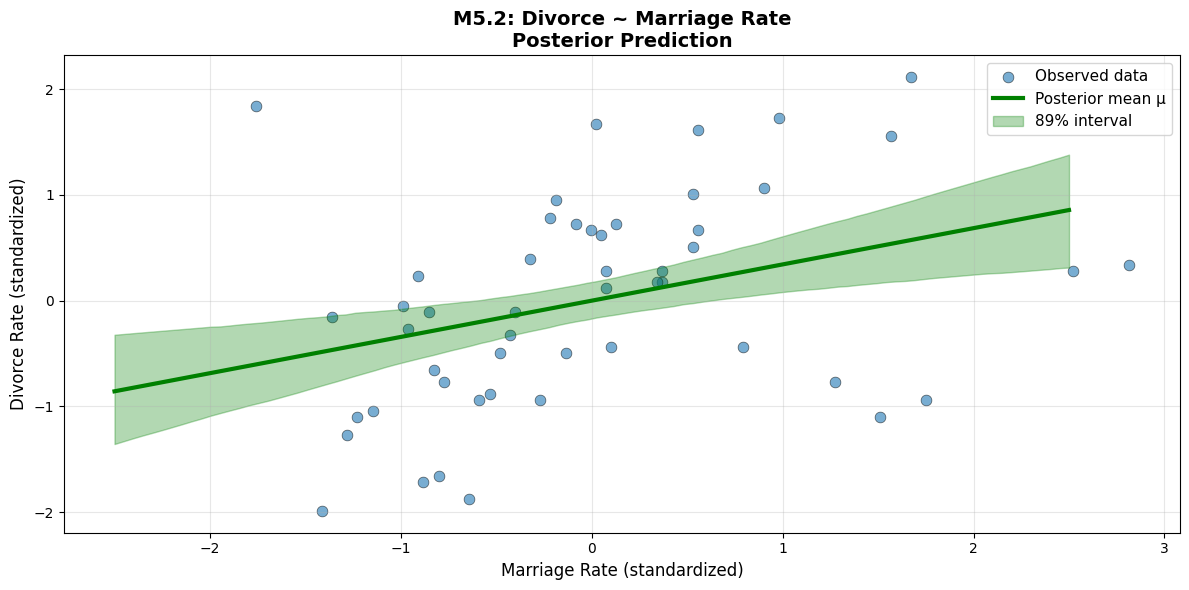

✓ Positive relationship: Higher marriage rate → Higher divorce


In [11]:
# Generate predictions
M_seq = np.linspace(-2.5, 2.5, 100)
post_m52 = m52.sample(n=1000, seed=42)

mu_samples_m52 = post_m52['alpha'].values[:, None] + post_m52['beta_M'].values[:, None] * M_seq[None, :]

mu_mean_m52 = mu_samples_m52.mean(axis=0)
mu_lower_m52 = np.percentile(mu_samples_m52, 5.5, axis=0)
mu_upper_m52 = np.percentile(mu_samples_m52, 94.5, axis=0)

# Plot
plt.figure(figsize=(12, 6))

plt.scatter(M, D, alpha=0.6, s=60, edgecolor='black', linewidth=0.5, label='Observed data')
plt.plot(M_seq, mu_mean_m52, 'g-', linewidth=3, label='Posterior mean μ')
plt.fill_between(M_seq, mu_lower_m52, mu_upper_m52, alpha=0.3, color='green', label='89% interval')

plt.xlabel('Marriage Rate (standardized)', fontsize=12)
plt.ylabel('Divorce Rate (standardized)', fontsize=12)
plt.title('M5.2: Divorce ~ Marriage Rate\nPosterior Prediction', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✓ Positive relationship: Higher marriage rate → Higher divorce")

---

## Compare M5.1 and M5.2

Let's compare the two models side-by-side.

In [12]:
# Comparison table
comparison = pd.DataFrame({
    'M5.1 (Age)': [
        f"{coef_m51['alpha']:.3f}",
        f"{coef_m51['beta_A']:.3f}",
        "—",
        f"{sigma_m51:.3f}"
    ],
    'M5.2 (Marriage)': [
        f"{coef_m52['alpha']:.3f}",
        "—",
        f"{coef_m52['beta_M']:.3f}",
        f"{sigma_m52:.3f}"
    ]
}, index=['α', 'βA', 'βM', 'σ'])

print("Model Comparison:")
print("="*70)
print(comparison)
print("\nObservations:")
print("• Both predictors show relationships with divorce")
print("• Age: Strong NEGATIVE effect")
print("• Marriage rate: POSITIVE effect")
print("• But are these real or confounded?")
print("• Next: Multiple regression will reveal the truth!")

Model Comparison:
   M5.1 (Age) M5.2 (Marriage)
α       0.000           0.000
βA     -0.568               —
βM          —           0.350
σ       0.804           0.929

Observations:
• Both predictors show relationships with divorce
• Age: Strong NEGATIVE effect
• Marriage rate: POSITIVE effect
• But are these real or confounded?
• Next: Multiple regression will reveal the truth!


---

## Making Predictions with Standardized Models

**Critical Question:** When we fit models on standardized data, how do we make predictions for new observations?

### The Workflow

1. **Training**: Standardize using training data statistics (save mean & std)
2. **Prediction**: Standardize new data using **training statistics**
3. **Un-standardize**: Convert predictions back to original scale

**Important:** Always use training data statistics, never re-compute from new data!

---

In [ ]:
# Example: Predict divorce rate for hypothetical new states

# Save training data statistics (CRITICAL!)
mean_age_train = age.mean()
std_age_train = age.std()
mean_divorce_train = divorce.mean()
std_divorce_train = divorce.std()

print("Training Data Statistics (saved for future predictions):")
print("="*70)
print(f"Age:     mean = {mean_age_train:.2f} years, std = {std_age_train:.2f} years")
print(f"Divorce: mean = {mean_divorce_train:.2f} per 1000, std = {std_divorce_train:.2f} per 1000")
print("="*70)

# Scenario 1: Late marriage (age = 28 years)
age_new1 = 28.0
print(f"\n\nScenario 1: Predict divorce for state with marriage age = {age_new1} years")
print("-"*70)

# Step 1: Standardize using TRAINING statistics
age_new1_std = (age_new1 - mean_age_train) / std_age_train
print(f"Step 1 - Standardize: ({age_new1} - {mean_age_train:.2f}) / {std_age_train:.2f} = {age_new1_std:.3f}")

# Step 2: Get posterior samples
post = m51.sample(n=1000, seed=42)

# Step 3: Predict in standardized units
mu_std_samples = post['alpha'].values + post['beta_A'].values * age_new1_std
mu_std_mean = mu_std_samples.mean()
mu_std_lower = np.percentile(mu_std_samples, 5.5)
mu_std_upper = np.percentile(mu_std_samples, 94.5)

print(f"Step 2 - Predict (standardized): μ_std = {mu_std_mean:.3f} [{mu_std_lower:.3f}, {mu_std_upper:.3f}]")

# Step 4: Un-standardize to get original scale
divorce_pred_mean = mu_std_mean * std_divorce_train + mean_divorce_train
divorce_pred_lower = mu_std_lower * std_divorce_train + mean_divorce_train
divorce_pred_upper = mu_std_upper * std_divorce_train + mean_divorce_train

print(f"Step 3 - Un-standardize: {mu_std_mean:.3f} * {std_divorce_train:.2f} + {mean_divorce_train:.2f}")
print(f"         → Predicted divorce = {divorce_pred_mean:.2f} per 1000")
print(f"         → 89% interval: [{divorce_pred_lower:.2f}, {divorce_pred_upper:.2f}]")

# Scenario 2: Early marriage (age = 24 years)
age_new2 = 24.0
print(f"\n\nScenario 2: Predict divorce for state with marriage age = {age_new2} years")
print("-"*70)

age_new2_std = (age_new2 - mean_age_train) / std_age_train
mu_std_samples2 = post['alpha'].values + post['beta_A'].values * age_new2_std
mu_std_mean2 = mu_std_samples2.mean()

divorce_pred_mean2 = mu_std_mean2 * std_divorce_train + mean_divorce_train

print(f"Standardized age: {age_new2_std:.3f}")
print(f"Predicted divorce = {divorce_pred_mean2:.2f} per 1000")
print(f"\n✓ Early marriage (24y) → Higher divorce ({divorce_pred_mean2:.2f})")
print(f"✓ Late marriage (28y) → Lower divorce ({divorce_pred_mean:.2f})")

### Key Takeaways

**The Prediction Pipeline:**
1. Save training statistics (mean, std) when you fit the model
2. Standardize new data using **training statistics** (never re-compute!)
3. Get predictions from posterior (result is in standardized units)
4. Un-standardize predictions back to original units

**Why this matters:**
- The posterior is in standardized scale (because we trained on standardized data)
- Must transform new inputs the same way as training data
- Must transform predictions back to be interpretable

**Common mistake:** Re-computing mean/std from new data → Wrong! Always use training statistics.

---

---

## Summary

### M5.1: Divorce ~ Age
- **βA < 0**: Older marriage age associated with lower divorce
- Strong, clear relationship

### M5.2: Divorce ~ Marriage Rate
- **βM > 0**: Higher marriage rate associated with higher divorce
- Also appears significant

### The Question

**Both predictors appear to matter.** But:
- What happens when we include BOTH?
- Are they telling us different things?
- Or is one effect spurious (confounded)?

### Next Steps

**Notebook 3: Multiple Regression**
- Fit M5.3: D ~ A + M
- Compare coefficients across models
- Discover which effects are real vs confounded

**Spoiler:** One of these relationships will nearly disappear!

---